## Multi-generation climate model inter-comparison

This notebook uses [`intake-esm`](https://intake-esm.readthedocs.io/en/latest/) to ingest and organize climate model output from various model generations from 1990-2019 and [`xskillscore`](https://github.com/raybellwaves/xskillscore) to calculate model skill with respect to NCEP Reanalysis 

In [41]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!
import intake
# util.py is in the local directory
# it contains code that is common across project notebooks
# or routines that are too extensive and might otherwise clutter
# the notebook design
import util 

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 

## Data catalogs

In [42]:
col = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")
col

pangeo-cmip6-ESM Collection with 28691 entries:
	> 10 activity_id(s)

	> 23 institution_id(s)

	> 48 source_id(s)

	> 29 experiment_id(s)

	> 86 member_id(s)

	> 23 table_id(s)

	> 190 variable_id(s)

	> 7 grid_label(s)

	> 28691 zstore(s)

	> 59 dcpp_init_year(s)

### Defining a regridding function

In [43]:
# Choose how much to coarsen data
coarsen_size = 3

# Define the common target grid axes
dlon, dlat = 1., 1.
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-90.+dlat/2., 90., dlat)),
                     'lon': (['lon'], np.arange(0.+dlon/2., 360., dlon)),})

# Regridding function
def regrid_to_common(ds, ds_out):
    """
    Regrid from rectilinear grid to common grid
    """
    regridder = xe.Regridder(ds, ds_out, 'bilinear',periodic=True, reuse_weights=True)
    return regridder(ds)

### Loading data

`intake-esm` enables loading data directly into an [xarray.Dataset](http://xarray.pydata.org/en/stable/api.html#dataset).

Note that data on the cloud are in 
[zarr](https://zarr.readthedocs.io/en/stable/) format and data on 
[glade](https://www2.cisl.ucar.edu/resources/storage-and-file-systems/glade-file-spaces) are stored as 
[netCDF](https://www.unidata.ucar.edu/software/netcdf/) files. This is opaque to the user.

`intake-esm` has rules for aggegating datasets; these rules are defined in the collection-specification file.

In [44]:
cat = col.search(experiment_id='historical', 
                 table_id='Amon', 
                 variable_id='tas',
                 member_id = 'r1i1p1f1')

In [45]:
time_slice = slice('1900','2013')

In [46]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False})

ds_dict = {}
for name, ds in tqdm(dset_dict.items()):
    # rename spatial dimensions if necessary
    if ('longitude' in ds.dims) and ('latitude' in ds.dims):
        ds = ds.rename({'longitude':'lon', 'latitude': 'lat'})
    ds = xr.decode_cf(ds) # Need this temporarily because setting 'decode_times': True appears broken
    ds = ds.sel(time=time_slice)
    
    # regrid to common grid
    ds_new = regrid_to_common(ds['tas'], ds_out)
    ds_new.attrs.update(ds.attrs)
    
    # drop redundant variables (like "height: 2m")
    for coord in ds_new.coords:
        if coord not in ['lat','lon','time']:
            ds_new = ds_new.drop(coord)

    # Add ensemble as new dimension
    ds_new = ds_new.expand_dims({'ensemble': np.array([name])}, 0)

    # Coarsen (to make data more manageable)
    ds_new = ds_new.coarsen({'lat': coarsen_size, 'lon': coarsen_size}, boundary='exact').mean()

    Rearth = 6.378E6   # radius of Earth in meters
    # a DataArray that gives grid cell areas on the lat/lon grid (in units of m^2)
    ds_new['area'] = (
        (np.deg2rad(dlat)*Rearth) *
        (np.deg2rad(dlon)*Rearth*np.cos(np.deg2rad(ds_new['lat'])) *
         xr.ones_like(ds_new['lon']))
    )

    # coarsen
    ds_new['area'] = ds_new['area'].coarsen(
        {'lat': coarsen_size, 'lon': coarsen_size}, boundary='exact'
    ).mean()
    
    ds_dict[name] = ds_new

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 19 group(s)


Create weight file: bilinear_160x320_180x360_peri.nc
Create weight file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Create weight file: bilinear_180x360_180x360_peri.nc
Create weight file: bilinear_256x512_180x360_peri.nc
Create weight file: bilinear_143x144_180x360_peri.nc
Create weight file: bilinear_128x256_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Create weight file: bilinear_90x144_180x360_peri.nc
Reuse existing file: bilinear_90x144_180x360_peri.nc
Reuse existing file: bilinear_90x144_180x360_peri.nc
Create weight file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Create weight file: bilinear_180x288_180x360_peri.nc
Reuse existing file: bilinear_180x288_180x360_peri.nc
Create weight file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Create weight file: bilinear_80x96_180x360_p

In [47]:
gmst_dict = {}

for name, ds_new in ds_dict.items():
    gmst = (ds_new*ds_new['area']).mean(dim=['lat','lon']) / ds_new['area'].mean(dim=['lat','lon'])
    gmst = gmst - gmst.sel(time=slice('1900','1950')).mean(dim='time')
    gmst_climatology = gmst.groupby('time.month').mean('time')
    gmst_anomalies = gmst.groupby('time.month') - gmst_climatology
    gmst_ann_anomalies = gmst_anomalies.groupby('time.year').mean('time').compute()
    
    gmst_dict[name] = gmst_ann_anomalies.squeeze()

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/indexing.py:1311: PerformanceWarning: Slicing with an out-of-order index is generating 38 times more chunks
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/indexing.py:1311: PerformanceWarning: Slicing with an out-of-order index is generating 38 times more chunks
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/indexing.py:1311: PerformanceWarning: Slicing with an out-of-order index is generating 38 times more chunks
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/indexing.py:1311: PerformanceWarning: Slicing with an out-of-order index is generating 38 times more chunks
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/indexing.py:1311: PerformanceWarning: Slicing with an out-of-order index is generating 50 times more chunks
  return self.array[key]
/srv/conda

Text(0, 0.5, 'global-mean surface temperature ($^{\\circ}$C)\n(relative to 1900-1950)')

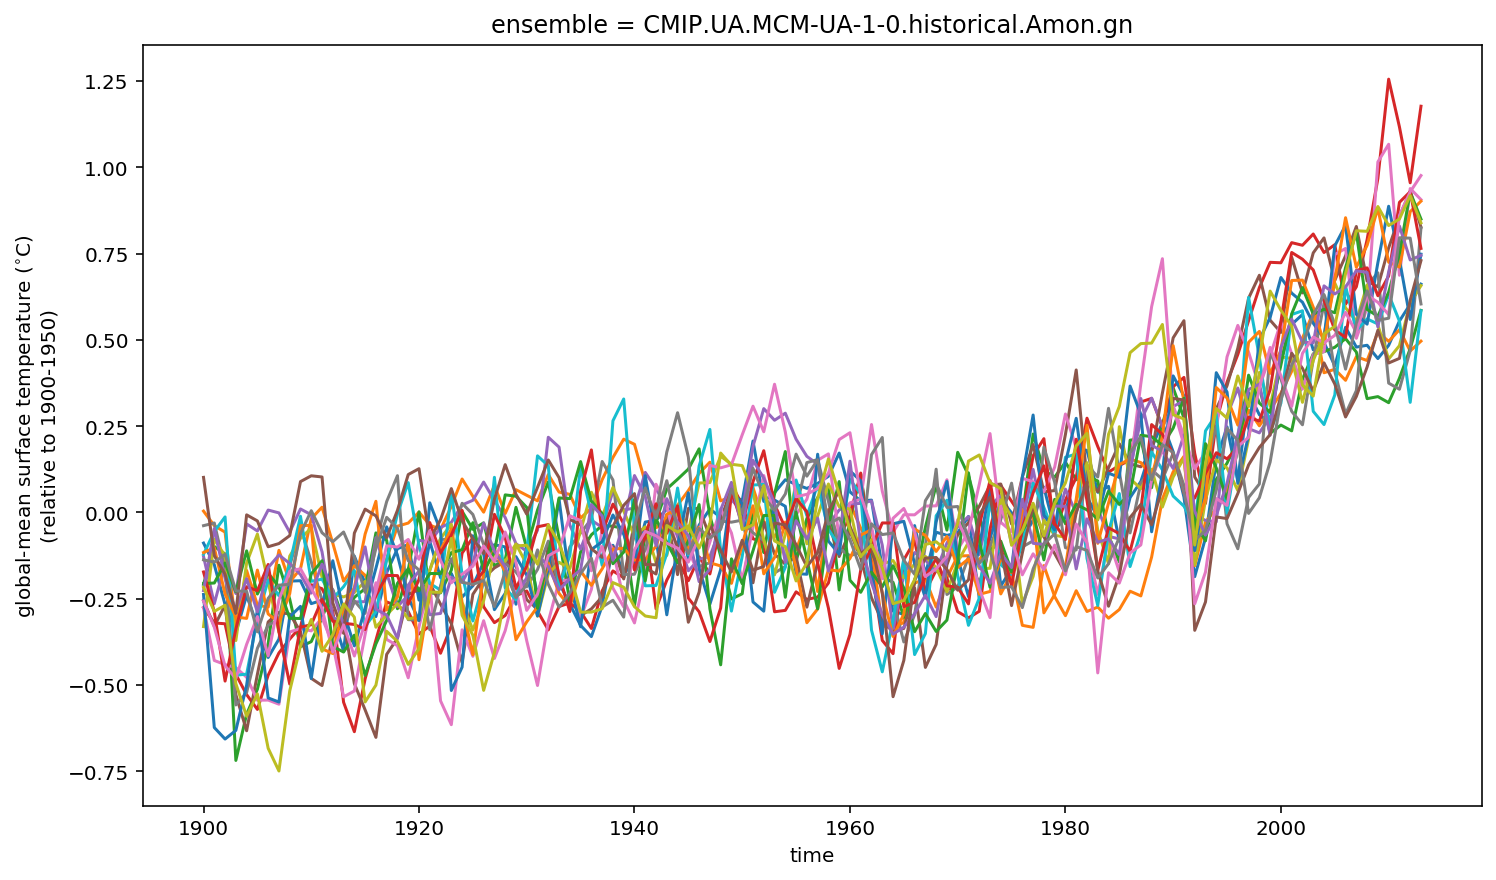

In [56]:
plt.figure(figsize=(12,7))

for name, gmst in gmst_dict.items():
    gmst.plot()
    
plt.xlabel('time')
plt.ylabel(r'global-mean surface temperature ($^{\circ}$C)'
           '\n'
           '(relative to 1900-1950)')
